# Overview of Scenario
***
The following demonstrations will detect fraudulent labels by using a copyrighted image as a base target image.
Other real valid labels were collected to test the fraud detection system. A few copyrighted labels were photoshopped to mimic fraud. The notebook will display images of labels that the deep learning one shot system selects as being fraudulent. Then the notebook will display images of labels that the system selects as being non-fradulent.

* First: Configure the deep learning model
* Second: Show which is the target beer label image
* Third: Show which images the fraud detection system selects as fraudulent
* Fourth: Show which images the fraud detection system selects as non-fraudulent
* Fifth: Show all test beer label images

# Configure the deep learning model
***
This section of the notebook configures, and creates the deep learning model needed for the beer label fraud detection process.

111.62964


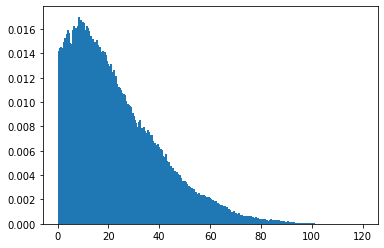

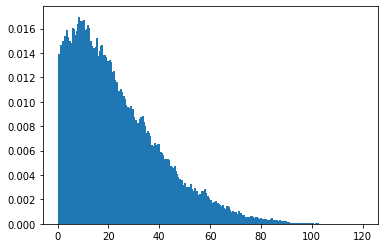

0.035567303093112235


In [198]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import os

testdata_dir = os.environ['MLDIR'] + "/TestData/"
from numpy.random import seed
seed(200)
tf.compat.v1.random.set_random_seed(1000)

img_shape = (224, 224, 3)
l2_reg = 0
# Create the Deep Learning Model to detect fraudulent labels
# Layer 1
alexnet = Sequential()
alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape, padding='same', kernel_regularizer=l2(l2_reg)))
#alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape, padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))
# Layer 2 
alexnet.add(Conv2D(256, (5, 5), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Load the validation image, or target image
subject01 = Image.open(testdata_dir + 'label_fraud/beer_label_fraud/Bud_Label.png')

# Load in input image
subject02 = Image.open(testdata_dir + 'label_fraud/beer_label_fraud/images/Beer_Label_22.png')

# Normalize the input images
subject01 = subject01.convert('RGB')
subject02 = subject02.convert('RGB')
subj01 = subject01.resize((224, 224))
subj02 = subject02.resize((224, 224))
subj01_a = np.array(subj01)
subj02_a = np.array(subj02)


#Here's where we do some voodoo
x[0] = subj01_a
x[1] = subj02_a
x_out_1 = alexnet.predict(x[0:2])
x_out_1_r = np.ravel(x_out_1[0])
x_out_2_r = np.ravel(x_out_1[1])

print(str(x_out_1_r.max()))
bin_group = 20
max_histo_level = int(x_out_1_r.max()/bin_group + 1)*bin_group
num_bins = 2*max_histo_level
be_l, hist_l = np.histogram(x_out_1_r, bins=num_bins, range=[0.0, max_histo_level], density = True)
plt.bar(hist_l[1:-1], be_l[1:])
plt.show()

# Calculate the
be_h, hist_h = np.histogram(x_out_2_r, bins=num_bins, range=[0.0, max_histo_level], density = True)
plt.bar(hist_h[1:-1], be_h[1:])
plt.show()

cor02 = np.dot(be_h[1:], be_l[1:])
cor02 = sum(np.abs(be_l[1:] - be_h[1:]))
print(str(cor02))


# Target Image

Below is the target image. This image represents the company's copyrighted image that we will be used to determine fraudulent images.  This is a registered trademark and all other images will be compared against it:

![alt text](./TestData/label_fraud/beer_label_fraud/Bud_LabelSmall.png "Logo Title Text 1")

# Dataset Construction

The images collected were used for only demonstration purposes. They were collected from the web, and were real beer labels. The synthetic test data to mimic fraud data was created with photoshop. In all 25 test beer labels, and one target beer label was created.

# Detected Fradulent Labels:
***
From the constructed dataset, the fraud detection system now will detect which labels are fraudulent.

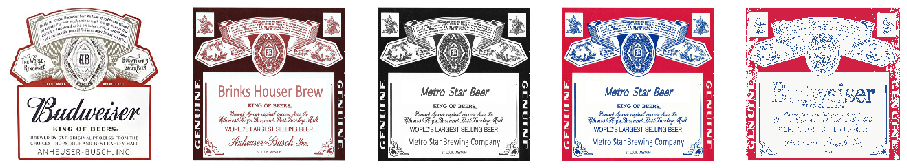

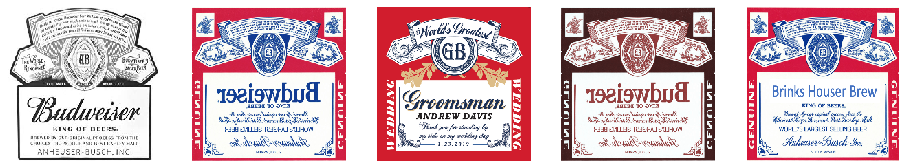

In [204]:
import glob
import cv2

mypath = testdata_dir + '/label_fraud/beer_label_fraud/images/'
file_list = []
for filename in glob.glob(mypath + '*.png'):
    file_list.append(filename)
    
for filename in glob.glob(mypath + '*.jpg'):
    file_list.append(filename)
    
for filename in glob.glob(mypath + '*.jpeg'):
    file_list.append(filename)
    
for filename in glob.glob(mypath + '*.gif'):
    file_list.append(filename)
    
similar_diff = 0.12
img_list = []
for fn in file_list:
    # Load test beer label image
    subject02 = Image.open(fn)
    
    # Normalize beer label image
    subject02 = subject02.convert('RGB')
    subj02 = subject02.resize((224, 224))
    subj02_a = np.array(subj02)
    save_0 = subj02_a[:,:,0]
    save_1 = subj02_a[:,:,1]
    x[0] = subj02_a

    # Process normalized beer label through model to generate feature vectors
    x_out_2 = alexnet.predict(x[0:1])
    x_out_2_r = np.ravel(x_out_2[0])
    
    # Generate histogram, and correlation product to determine if the label is fraudulent
    be_h, hist_h = np.histogram(x_out_2_r, bins=num_bins, range=[0.0, max_histo_level], density = True)
    cor02 = sum(np.abs(be_l[1:]- be_h[1:]))
    # Threshold the correlation product to determine fraudulence
    if(cor02 < similar_diff):
        img_list.append(subj02_a)
# Plot the fraudulent beer labels
num_figs = 5
num_blocks = int(len(img_list)/num_figs)
index = 0
for kk in range(num_blocks):
    (a1, a2) = plt.subplots(1,5, figsize=(16, 16))
    for ii in range(5):
        a2[ii].imshow(img_list[index])
        a2[ii].axis('off')
        index += 1
    plt.show()
    
left_over = len(img_list)%num_figs
if(left_over > 0):
    (a1, a2) = plt.subplots(1,left_over, figsize=(10, 10))
    for ii in range(left_over):
        a2[ii].imshow(img_list[index])
        a2[ii].axis('off')
        index += 1
    plt.show()

# Detected Non-Fraudulent Labels:
***
From the constructed dataset, the fraud detection system now will detect which labels are non-fraudulent.

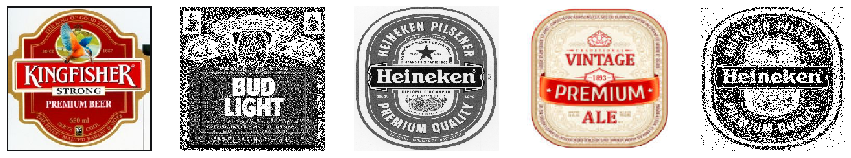

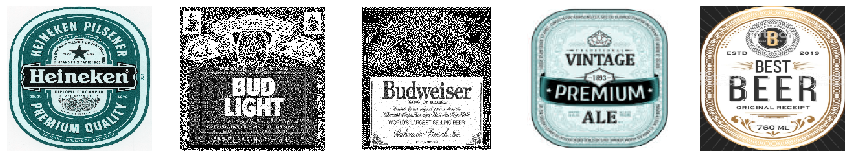

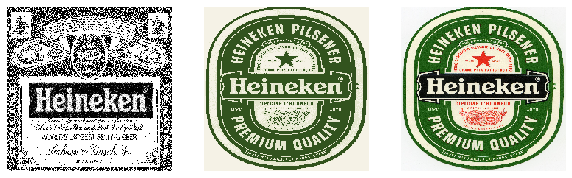

In [211]:

file_list = []
for filename in glob.glob(mypath + '*.png'):
    file_list.append(filename)
    
for filename in glob.glob(mypath + '*.jpg'):
    file_list.append(filename)
    
for filename in glob.glob(mypath + '*.jpeg'):
    file_list.append(filename)
    
for filename in glob.glob(mypath + '*.gif'):
    file_list.append(filename)
    
similar_diff = 0.12
img_list = []
img_cnt = 0
for fn in file_list:
    
    # Load input beer label image
    subject02 = Image.open(fn)
    # Normalize input beer labe image
    subject02 = subject02.convert('RGB')
    subj02 = subject02.resize((224, 224))
    subj02_a = np.array(subj02)  
    x[0] = subj02_a
    
    # Process normalized beer label through model to generate feature vectors
    x_out_2 = alexnet.predict(x[0:1])
    x_out_2_r = np.ravel(x_out_2[0])
    # Generate histogram, and correlation product to determine if the label is fraudulent
    be_h, hist_h = np.histogram(x_out_2_r, bins=240, range=[0.0, 120.0], density = True)
    cor02 = sum(np.abs(be_l[1:]- be_h[1:]))

    # Threshold the correlation product to determine fraudulence
    if(cor02 > similar_diff):
        img_list.append(subj02_a)
        img_cnt += 1

    # Display non-fraudulent beer labels
    if(img_cnt >= num_figs):
        (a1, a2) = plt.subplots(1,5, figsize=(15,15))
        index = 0
        for ii in range(5):
            a2[ii].imshow(img_list[index])
            a2[ii].axis('off')
            index += 1
        plt.show()
        img_list = []
        img_cnt = 0

if (img_cnt > 0):
    index = 0
    (a1, a2) = plt.subplots(1,img_cnt, figsize=(10,10))
    for ii in range(img_cnt):
        a2[ii].imshow(img_list[index])
        a2[ii].axis('off')
        index += 1    
    plt.show()



# Complete Data Test 
***
Below are all the images in the test dataset, 10 are fraudulent, and 15 are non-fradulent.

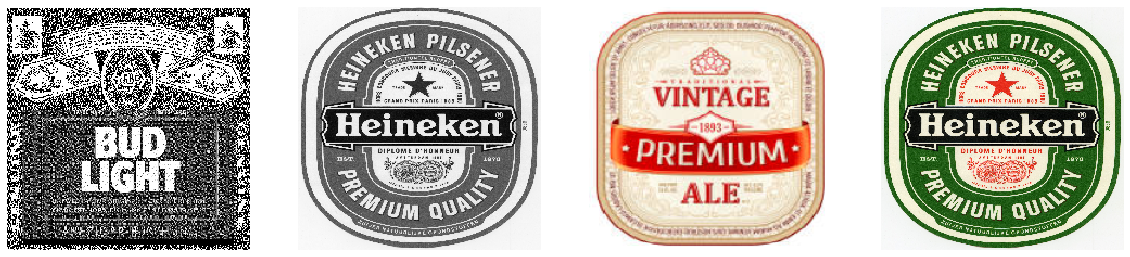

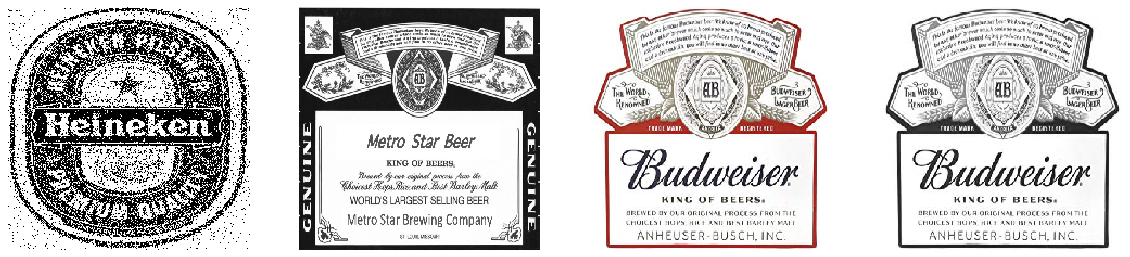

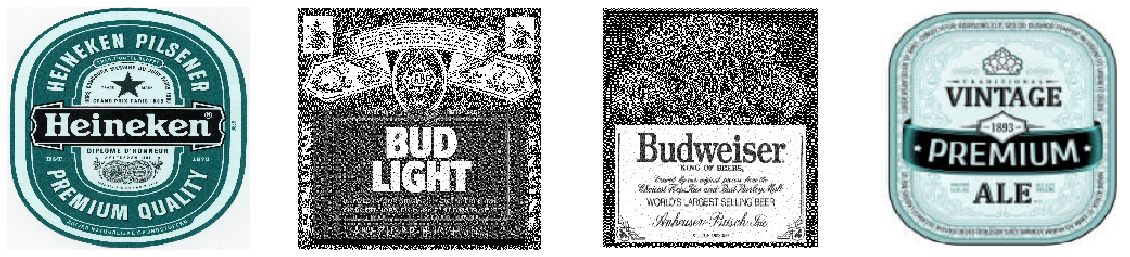

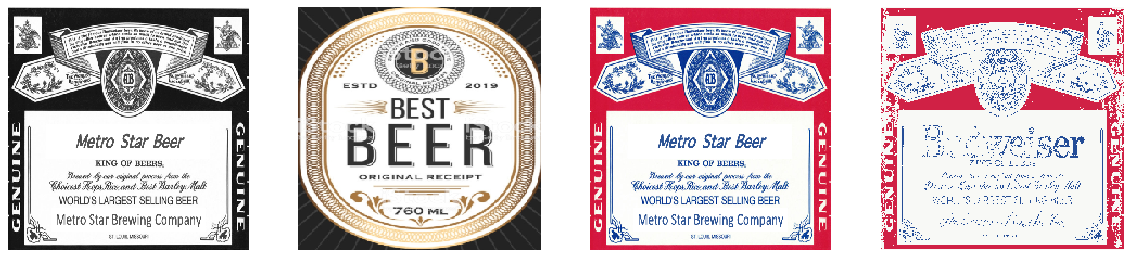

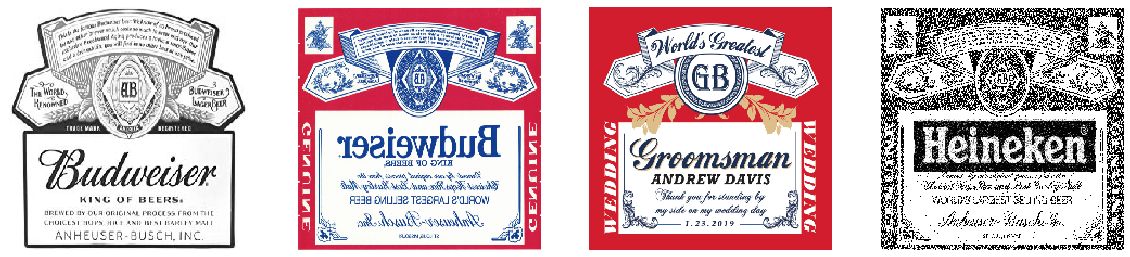

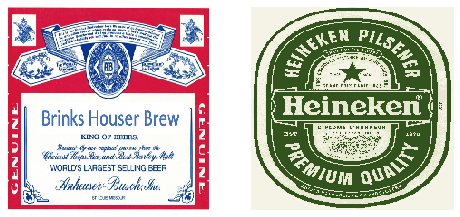

In [157]:
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(filenames)
    break
    
img_list = []
# For every image in mypath directory
for fn in f[0]:
    # Load test beer label image
    subject02 = Image.open(mypath + fn)
    # Normalize beer label image
    subject02 = subject02.convert('RGB')
    subj02 = subject02.resize((224, 224))
    subj02_a = np.array(subj02)

    img_list.append(subj02_a)
    
# Display the test beer labels
(a1, a2) = plt.subplots(1,4, figsize=(20,20))
index = 0
for ii in range(4):
    a2[ii].imshow(img_list[index])
    a2[ii].axis('off')
    index += 1
plt.show()

(a1, a2) = plt.subplots(1,4, figsize=(20,20))
for ii in range(4):
    a2[ii].imshow(img_list[index])
    a2[ii].axis('off')
    index += 1
plt.show()

(a1, a2) = plt.subplots(1,4, figsize=(20,20))
for ii in range(4):
    a2[ii].imshow(img_list[index])
    a2[ii].axis('off')
    index += 1
plt.show()

(a1, a2) = plt.subplots(1,4, figsize=(20,20))
for ii in range(4):
    a2[ii].imshow(img_list[index])
    a2[ii].axis('off')
    index += 1
plt.show()

(a1, a2) = plt.subplots(1,4, figsize=(20,20))
for ii in range(4):
    a2[ii].imshow(img_list[index])
    a2[ii].axis('off')
    index += 1
plt.show()

(a1, a2) = plt.subplots(1,2, figsize=(8,8))
for ii in range(2):
    a2[ii].imshow(img_list[index])
    a2[ii].axis('off')
    index += 1
plt.show()
